In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import itertools

In [2]:
profiles = {
    "ORF": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "CRISPR": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected",
}

color_discrete_map = {
    "ORF": "rgb(0, 158, 115)",
    "CRISPR": "rgb(213, 94, 0)",
}

gene_labels = {
    "Protein Class": "protein_class",
    "Disease Association": "disease_association",
    "CORUM Complex": "corum_complex",
    "Wikipathway": "wikipathway",
    "HGNC Gene Group": "gene-group",
}

label_columns = {
    "Protein Class": "Metadata_protein_class_list",
    "Disease Association": "Metadata_disease_list",
    "CORUM Complex": "Metadata_corum_complex_list",
    "Wikipathway": "Metadata_wikipathway_list",
    "HGNC Gene Group": "Metadata_gene_group_list",
}

Read phenotypic activity data

In [3]:
phenotypic_activity_df = pd.DataFrame()

for profile in profiles:
    df = pd.read_csv(f"output/phenotypic-activity-{profiles[profile]}.csv.gz")
    df["profile_type"] = profile
    phenotypic_activity_df = pd.concat(
        [phenotypic_activity_df, df], ignore_index=True, axis=0
    )

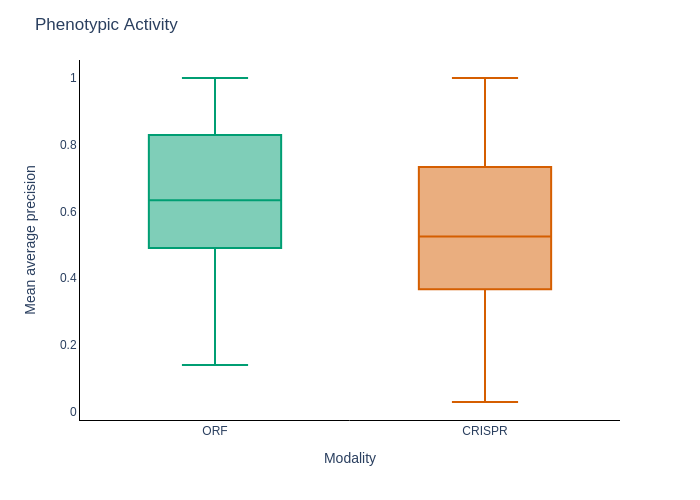

In [4]:
fig = px.box(
    phenotypic_activity_df,
    x="profile_type",
    y="mean_average_precision",
    color="profile_type",
    color_discrete_map=color_discrete_map,
).update_layout(
    title="Phenotypic Activity",
    xaxis=dict(title="Modality", linecolor="black"),
    yaxis=dict(title="Mean average precision", linecolor="black"),
    plot_bgcolor="white",
    showlegend=False,
)

fig.show("png")
fig.write_image("figures/phenotypic-activity.png", height=480, width=640, scale=2)
fig.write_image("figures/phenotypic-activity.svg", height=480, width=640, scale=2)

In [5]:
fraction_retrieved = (
    phenotypic_activity_df.groupby("profile_type")
    .below_corrected_p.apply(lambda x: (x == True).sum() / len(x))
    .reset_index()
    .rename(columns={"below_corrected_p": "fraction_retrieved"})
)

print(fraction_retrieved.to_markdown(index=False))

| profile_type   |   fraction_retrieved |
|:---------------|---------------------:|
| CRISPR         |             0.695772 |
| ORF            |             0.568964 |


In [6]:
n_retrieved = (
    phenotypic_activity_df.groupby("profile_type")
    .below_corrected_p.apply(lambda x: (x == True).sum())
    .reset_index()
    .rename(columns={"below_corrected_p": "n_retrieved"})
)

print(n_retrieved.to_markdown(index=False))

| profile_type   |   n_retrieved |
|:---------------|--------------:|
| CRISPR         |          5546 |
| ORF            |          7817 |


In [7]:
gene_label_retrieval_df = pd.DataFrame()

for gene_label in gene_labels:
    df = (
        pd.read_parquet(f"output/{gene_labels[gene_label]}_retrieval.parquet")[
            ["mean_average_precision", "below_corrected_p", "Modality", "p_value", "corrected_p_value"]
        ]
        .assign(gene_label=gene_label)
    )
    gene_label_retrieval_df = pd.concat(
        [gene_label_retrieval_df, df], ignore_index=True, axis=0
    )

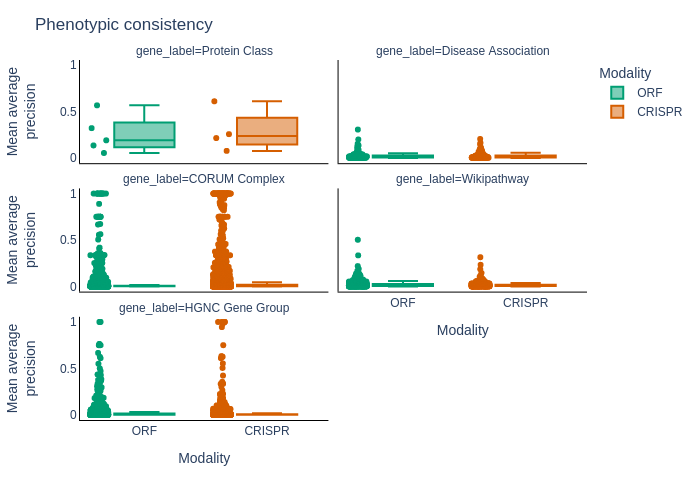

In [8]:
fig = (
    px.box(
        gene_label_retrieval_df,
        x="Modality",
        y="mean_average_precision",
        color="Modality",
        color_discrete_map=color_discrete_map,
        facet_col="gene_label",
        facet_col_wrap=2,
        points="all",
    )
    .update_layout(
        title="Phenotypic consistency",
        xaxis1=dict(title="Modality",linecolor="black"),
        xaxis3=dict(linecolor="black"),
        xaxis4=dict(title="Modality", linecolor="black", showticklabels=True),
        xaxis5=dict(linecolor="black"),
        xaxis6=dict(linecolor="black"),
        yaxis1=dict(title=f"Mean average<br>precision", linecolor="black"),
        yaxis3=dict(title=f"Mean average<br>precision", linecolor="black"),
        yaxis4=dict(linecolor="black"),
        yaxis5=dict(title=f"Mean average<br>precision",linecolor="black"),
        yaxis6=dict(linecolor="black"),
        plot_bgcolor="white",
    )
)

fig.show("png")
fig.write_image("figures/phenotypic-consistency-gene-labels.png", height=480, width=640, scale=2)
fig.write_image("figures/phenotypic-consistency-gene-labels.svg", height=480, width=640, scale=2)

In [9]:
print(
    gene_label_retrieval_df.query("below_corrected_p == True")
    .groupby(["Modality", "gene_label"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="Modality", columns="gene_label", values="mean_average_precision")
    .sort_index()
    [list(gene_labels.keys())]
    .fillna(0)
    .to_markdown()
)

| Modality   |   Protein Class |   Disease Association |   CORUM Complex |   Wikipathway |   HGNC Gene Group |
|:-----------|----------------:|----------------------:|----------------:|--------------:|------------------:|
| CRISPR     |               0 |                     3 |             369 |           152 |                89 |
| ORF        |               5 |                     2 |             103 |           347 |               196 |


In [10]:
common_labels_df = pd.DataFrame()

for gene_label in gene_labels:
    df = pd.read_parquet(f"output/{gene_labels[gene_label]}_retrieval.parquet")[
        [f"{label_columns[gene_label]}", "below_corrected_p", "Modality", "p_value", "corrected_p_value"]
    ]
    orf_df = df.query("Modality == 'ORF' and below_corrected_p == True")
    crispr_df = df.query("Modality == 'CRISPR' and below_corrected_p == True")
    merged_df = orf_df.merge(crispr_df, on=f"{label_columns[gene_label]}", how="inner")

    common_labels_df = pd.concat(
        [
            common_labels_df,
            pd.DataFrame(
                {
                    "ORF": len(orf_df),
                    "CRISPR": len(crispr_df),
                    "Common": len(merged_df),
                },
                index=[gene_label],
            ),
        ],
        axis=0,
    )

print(common_labels_df.to_markdown())

|                     |   ORF |   CRISPR |   Common |
|:--------------------|------:|---------:|---------:|
| Protein Class       |     5 |        0 |        0 |
| Disease Association |     2 |        3 |        0 |
| CORUM Complex       |   103 |      369 |       54 |
| Wikipathway         |   347 |      152 |       81 |
| HGNC Gene Group     |   196 |       89 |       13 |


In [11]:
phenotypic_activity_consistency_df = pd.concat(
    [
        phenotypic_activity_df[["profile_type", "mean_average_precision", "below_corrected_p"]]
        .assign(retrieval="Replicates")
        .rename(columns={"profile_type": "Modality"}),
        gene_label_retrieval_df[["Modality", "mean_average_precision", "gene_label", "below_corrected_p"]].rename(
            columns={"gene_label": "retrieval"}
        ),
    ],
    ignore_index=True,
)

In [12]:
# Number of points per plot
n_points_df = (
    phenotypic_activity_consistency_df.groupby(["retrieval", "Modality"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="retrieval", columns="Modality", values="mean_average_precision")
    .reset_index()
)

n_points_df

Modality,retrieval,CRISPR,ORF
0,CORUM Complex,1784,1326
1,Disease Association,119,123
2,HGNC Gene Group,777,947
3,Protein Class,4,5
4,Replicates,7971,13739
5,Wikipathway,783,770


In [13]:
n_retrieved_df = (
    phenotypic_activity_consistency_df.query("below_corrected_p == True")
    .groupby(["Modality", "retrieval"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="retrieval", columns="Modality", values="mean_average_precision")
).fillna(0)

n_retrieved_df = n_retrieved_df.astype(int).reset_index()
n_retrieved_df = n_retrieved_df.rename(
    columns={"ORF": "ORF_retrieved", "CRISPR": "CRISPR_retrieved"}
)
n_retrieved_df

Modality,retrieval,CRISPR_retrieved,ORF_retrieved
0,CORUM Complex,369,103
1,Disease Association,3,2
2,HGNC Gene Group,89,196
3,Protein Class,0,5
4,Replicates,5546,7817
5,Wikipathway,152,347


In [14]:
facet_text_df = n_points_df.merge(n_retrieved_df, on="retrieval", how="inner").assign(
    text=lambda x: x.apply(
        lambda y: f"{y['retrieval']}<br>ORF:{y['ORF_retrieved']}/{y['ORF']}<br>CRISPR:{y['CRISPR_retrieved']}/{y['CRISPR']}",
        axis=1,
    )
)

facet_text_df

Modality,retrieval,CRISPR,ORF,CRISPR_retrieved,ORF_retrieved,text
0,CORUM Complex,1784,1326,369,103,CORUM Complex<br>ORF:103/1326<br>CRISPR:369/1784
1,Disease Association,119,123,3,2,Disease Association<br>ORF:2/123<br>CRISPR:3/119
2,HGNC Gene Group,777,947,89,196,HGNC Gene Group<br>ORF:196/947<br>CRISPR:89/777
3,Protein Class,4,5,0,5,Protein Class<br>ORF:5/5<br>CRISPR:0/4
4,Replicates,7971,13739,5546,7817,Replicates<br>ORF:7817/13739<br>CRISPR:5546/7971
5,Wikipathway,783,770,152,347,Wikipathway<br>ORF:347/770<br>CRISPR:152/783


In [15]:
min_max_df = (
    phenotypic_activity_consistency_df.groupby(
        ["retrieval", "Modality", "below_corrected_p"]
    )
    .mean_average_precision.apply(
        lambda x: [np.percentile(x, 0.01), np.percentile(x, 99)]
    )
    .reset_index()
    .rename(columns={"mean_average_precision": "min_max"})
)

min_max_df.below_corrected_p = min_max_df.below_corrected_p.map({True: "True", False: "False"})

missing_rows = pd.DataFrame(
    {
        "retrieval": ["Protein Class", "Protein Class"],
        "Modality": ["ORF", "CRISPR"],
        "below_corrected_p": ["False", "True"],
        "min_max": [[0.0, 0.0], [0.0, 0.0]],
    }
)

min_max_df = pd.concat([min_max_df, missing_rows], ignore_index=True)

min_max_df.sort_values(["retrieval", "Modality", "below_corrected_p"], inplace=True)

min_max_df = (
    min_max_df.groupby(["retrieval", "Modality"])
    .min_max.apply(lambda x: [list(x)[0][0], list(x)[1][0]])
    .reset_index()
)

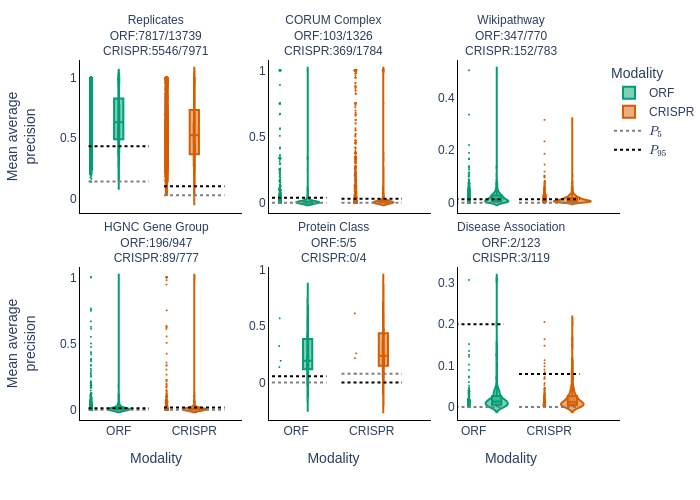

In [16]:
category_order = {
    "retrieval": [
        "Replicates",
        "CORUM Complex",
        "Wikipathway",
        "HGNC Gene Group",
        "Protein Class",
        "Disease Association",
    ]
}

fig = px.violin(
    phenotypic_activity_consistency_df,
    x="Modality",
    y="mean_average_precision",
    color="Modality",
    color_discrete_map=color_discrete_map,
    facet_col="retrieval",
    facet_col_wrap=3,
    category_orders=category_order,
    box=True,
    facet_col_spacing=0.05,
    facet_row_spacing=0.15,
).update_layout(
    # title="Phenotypic activity and consistency",
    xaxis1=dict(title="Modality", linecolor="black"),
    xaxis2=dict(title="Modality", linecolor="black"),
    xaxis3=dict(title="Modality", linecolor="black"),
    xaxis4=dict(linecolor="black"),
    xaxis5=dict(linecolor="black"),
    xaxis6=dict(linecolor="black"),
    yaxis1=dict(title=f"Mean average<br>precision", linecolor="black"),
    yaxis2=dict(linecolor="black"),
    yaxis3=dict(linecolor="black"),
    yaxis4=dict(title=f"Mean average<br>precision", linecolor="black"),
    yaxis5=dict(linecolor="black"),
    yaxis6=dict(linecolor="black"),
    plot_bgcolor="white",
)

fig = fig.update_yaxes(matches=None, showticklabels=True)

fig.update_traces(
    points="all", marker=dict(size=2), jitter=0.05, scalemode="width"  # show all points
)

fig.for_each_annotation(lambda x: x.update(text=x.text.split("=")[-1]))
fig.for_each_annotation(lambda x: x.update(text=facet_text_df.text[facet_text_df.retrieval == x.text].values[0]))

for label, idx in zip(
    category_order["retrieval"], itertools.product([2, 1], [1, 2, 3])
):
    min_max = min_max_df.query(
        "retrieval == @label and Modality == 'ORF'"
    ).min_max.values
    y_false_max = min_max[0][0]
    y_true_min = min_max[0][1]
    fig.add_shape(
        type="line",
        x0=-0.4,
        x1=0.4,
        y0=y_false_max,
        y1=y_false_max,
        line=dict(dash="dot", color="grey"),
        row=idx[0],
        col=idx[1],
    )

    fig.add_shape(
        type="line",
        x0=-0.4,
        x1=0.4,
        y0=y_true_min,
        y1=y_true_min,
        line=dict(dash="dot", color="black"),
        row=idx[0],
        col=idx[1],
    )

    min_max = min_max_df.query(
        "retrieval == @label and Modality == 'CRISPR'"
    ).min_max.values
    y_false_max = min_max[0][0]
    y_true_min = min_max[0][1]

    fig.add_shape(
        type="line",
        x0=0.6,
        x1=1.4,
        y0=y_false_max,
        y1=y_false_max,
        line=dict(dash="dot", color="grey"),
        row=idx[0],
        col=idx[1],
    )

    fig.add_shape(
        type="line",
        x0=0.6,
        x1=1.4,
        y0=y_true_min,
        y1=y_true_min,
        line=dict(dash="dot", color="black"),
        row=idx[0],
        col=idx[1],
    )

# Adding invisible lines for the legend
fig.add_scatter(
    x=["ORF", "ORF"],
    y=[y_false_max, y_false_max],
    mode="lines",
    line=dict(dash="dot", color="grey"),
    name=f"$P_{{{5}}}$",
    showlegend=True,
    row=idx[0],
    col=idx[1],
)

fig.add_scatter(
    x=["ORF", "ORF"],
    y=[y_true_min, y_true_min],
    mode="lines",
    line=dict(dash="dot", color="black"),
    name=f"$P_{{{95}}}$",
    showlegend=True,
    row=idx[0],
    col=idx[1],
)

fig.show("png")
fig.write_image(
    "figures/phenotypic-activity-consistency.png", height=480, width=640, scale=2
)
fig.write_image(
    "figures/phenotypic-activity-consistency.svg", height=480, width=640, scale=2
)

In [17]:
phenotypic_activity_consistency_df = pd.concat(
    [
        phenotypic_activity_df[
            [
                "profile_type",
                "mean_average_precision",
                "p_value",
                "corrected_p_value",
                "below_corrected_p",
            ]
        ]
        .assign(retrieval="Replicates")
        .rename(columns={"profile_type": "Modality"}),
        gene_label_retrieval_df[
            [
                "Modality",
                "mean_average_precision",
                "gene_label",
                "p_value",
                "corrected_p_value",
                "below_corrected_p",
            ]
        ].rename(columns={"gene_label": "retrieval"}),
    ],
    ignore_index=True,
)

In [18]:
phenotypic_activity_consistency_df.to_parquet("output/phenotypic-activity-consistency.parquet", index=False)